In [1]:
import os

WORKING_DIR = 'C:/Users/malik.kalembasi/OneDrive - Odine Solutions/Desktop/itu/machine_learning/term_project'
os.chdir(WORKING_DIR)
print(os.getcwd())

C:\Users\malik.kalembasi\OneDrive - Odine Solutions\Desktop\itu\machine_learning\term_project


In [2]:
# IMPORTS & ENV VARS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

DATA_DIR = os.path.join(WORKING_DIR, 'data')
RESULT_DIR = os.path.join(WORKING_DIR, 'results')

TEST_SPLIT_RATIO = 0.2
LAG_WEEKS = [4, 8, 12]
ROLLING_WEEKS = [4, 8, 12]
PEARSON_PRUNE_THRESHOLD = 0.95

LGBM_PARAM_GRID = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'min_child_samples': [20, 30]
}

In [3]:
# LOAD TRAIN DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan")
print("features: ", sj_train_features.shape)
print("labels  : ", sj_train_labels.shape)

print("\nIquitos")
print("features: ", iq_train_features.shape)
print("labels  : ", iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [4]:
# PREPROCESS DATA 

def preprocess_city_data(features, labels=None):
    """
    Merges features and labels, converts week_start_date to index,
    and handles missing values.
    """
    # 1. Merge features and labels if labels are provided
    if labels is not None:
        df = features.join(labels)
    else:
        df = features.copy()
    
    # 2. Reset index to move 'year' and 'weekofyear' from index to columns
    # This preserves them as features.
    df.reset_index(inplace=True)
    
    # 3. Convert week_start_date to datetime
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    # 4. Set week_start_date as index
    df.set_index('week_start_date', inplace=True)
    
    # 5. Drop 'city' column as it's constant for each model and not numeric
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    
    # 6. Fill Missing Values (Forward Fill for time series)
    df = df.ffill()
    
    return df

# Apply to San Juan and Iquitos
sj_train = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan Preprocessed Shape:", sj_train.shape)
print("Iquitos Preprocessed Shape:", iq_train.shape)
sj_train.head()

San Juan Preprocessed Shape: (936, 23)
Iquitos Preprocessed Shape: (520, 23)


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [5]:
# FEATURE EXTRACTION

def create_features(df, lag_weeks=LAG_WEEKS, rolling_weeks=ROLLING_WEEKS):
    """
    Creates lag and rolling window features.
    """
    df_eng = df.copy()
    
    # List of columns to create features for (exclude labels and non-numeric if any)
    # Typically climate variables
    feature_cols = [c for c in df.columns if c not in ['total_cases', 'year', 'weekofyear']]
    
    new_features = []
    
    for col in feature_cols:
        # Lag features
        for lag in lag_weeks:
            new_features.append(
                df_eng[col].shift(lag).rename(f'{col}_lag_{lag}')
            )
            
        # Rolling features
        for window in rolling_weeks:
            rolling_col = df_eng[col].rolling(window=window)
            
            new_features.append(rolling_col.mean().rename(f'{col}_rolling_mean_{window}'))
            new_features.append(rolling_col.std().rename(f'{col}_rolling_std_{window}'))
            new_features.append(rolling_col.min().rename(f'{col}_rolling_min_{window}'))
            new_features.append(rolling_col.max().rename(f'{col}_rolling_max_{window}'))
            new_features.append(rolling_col.kurt().rename(f'{col}_rolling_kurt_{window}'))
            
    # Concatenate all new features at once to avoid PerformanceWarning (fragmentation)
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
            
    # Drop rows with NaNs created by lag/rolling (or fill them)
    # For training, we usually drop the initial rows.
    df_eng.dropna(inplace=True)
    
    return df_eng

# Create engineered features
sj_train_eng = create_features(sj_train)
iq_train_eng = create_features(iq_train)

print("San Juan Engineered Shape:", sj_train_eng.shape)
print("Iquitos Engineered Shape:", iq_train_eng.shape)

San Juan Engineered Shape: (924, 383)
Iquitos Engineered Shape: (508, 383)


In [6]:
# PRUNE CORRELATED FEATURES

def prune_correlated_features(df, threshold=PEARSON_PRUNE_THRESHOLD, target_col='total_cases'):
    """
    Removes features that are highly correlated with each other (collinear).
    """
    # Exclude target from correlation calculation
    features = df.drop(columns=[target_col], errors='ignore')
    
    # Calculate correlation matrix
    corr_matrix = features.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Dropping {len(to_drop)} features due to high correlation (> {threshold})")
    # Optional: Print dropped columns
    # print(to_drop)
    
    # Drop features from the original dataframe
    df_pruned = df.drop(columns=to_drop)
    
    return df_pruned

# Apply pruning
print("Pruning San Juan Features...")
sj_train_eng = prune_correlated_features(sj_train_eng)

print("\nPruning Iquitos Features...")
iq_train_eng = prune_correlated_features(iq_train_eng)

print("\nSan Juan Pruned Shape:", sj_train_eng.shape)
print("Iquitos Pruned Shape:", iq_train_eng.shape)

Pruning San Juan Features...
Dropping 101 features due to high correlation (> 0.95)

Pruning Iquitos Features...
Dropping 59 features due to high correlation (> 0.95)

San Juan Pruned Shape: (924, 282)
Iquitos Pruned Shape: (508, 324)


In [7]:
# SPLIT DATA

def split_data(df, target_col='total_cases', test_size=TEST_SPLIT_RATIO):
    """
    Splits data into X and y, and then into train and test sets (time-based).
    """
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Time-based split
    split_index = int(len(df) * (1 - test_size))
    
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    return X_train, X_test, y_train, y_test

# Split San Juan
X_train_sj, X_test_sj, y_train_sj, y_test_sj = split_data(sj_train_eng)

# Split Iquitos
X_train_iq, X_test_iq, y_train_iq, y_test_iq = split_data(iq_train_eng)

print("San Juan Train/Test Shapes:", X_train_sj.shape, X_test_sj.shape)
print("Iquitos Train/Test Shapes:", X_train_iq.shape, X_test_iq.shape)

San Juan Train/Test Shapes: (739, 281) (185, 281)
Iquitos Train/Test Shapes: (406, 323) (102, 323)


In [8]:
# TRAIN BASELINE MODELS
# Train a LightGBM regressor
# objective='regression' (or 'poisson')
# TimeSeriesSplit for cross-validation to ensure we respect the temporal order of observations.

def train_evaluate_lgbm(X_train, y_train, X_test, y_test, params=None):
    """
    Trains a LightGBM model and evaluates it.
    """
    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'mae',
            'n_estimators': 100,
            'learning_rate': 0.1,
            'num_leaves': 31,
            'random_state': 42,
            'early_stopping_rounds': 10,
            'verbosity': -1
        }
        
    model = lgb.LGBMRegressor(**params)
    
    # Train
    model.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric='mae')
    
    # Predict
    predictions = model.predict(X_test)
    
    # Ensure non-negative predictions
    predictions = np.maximum(predictions, 0)
    
    # Evaluate
    mae = mean_absolute_error(y_test, predictions)
    
    return model, mae, predictions

# Train Baseline Models
print("Training San Juan Baseline...")
model_sj, mae_sj, preds_sj = train_evaluate_lgbm(X_train_sj, y_train_sj, X_test_sj, y_test_sj)
print(f"San Juan MAE: {mae_sj:.4f}")

print("\nTraining Iquitos Baseline...")
model_iq, mae_iq, preds_iq = train_evaluate_lgbm(X_train_iq, y_train_iq, X_test_iq, y_test_iq)
print(f"Iquitos MAE: {mae_iq:.4f}")

Training San Juan Baseline...
San Juan MAE: 23.6884

Training Iquitos Baseline...
Iquitos MAE: 7.4326


In [9]:
# HYPERPARAMETER TUNING WITH GRID SEARCH AND TIMESERIESSPLIT

def tune_lgbm(X, y):
    """
    Performs Grid Search with TimeSeriesSplit.
    """
    # Define parameter grid
    param_grid = LGBM_PARAM_GRID
    
    lgbm_model = lgb.LGBMRegressor(objective='regression', random_state=42, verbosity=-1)
    
    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=3)
    
    grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, 
                               cv=tscv, scoring='neg_mean_absolute_error', 
                               verbose=1, n_jobs=-1)
    
    grid_search.fit(X, y)
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best MAE (CV):", -grid_search.best_score_)
    
    return grid_search.best_estimator_

# Tune San Juan (using training set only to avoid leakage)
print("Tuning San Juan Model...")
best_model_sj = tune_lgbm(X_train_sj, y_train_sj)

# Tune Iquitos
print("\nTuning Iquitos Model...")
best_model_iq = tune_lgbm(X_train_iq, y_train_iq)

Tuning San Juan Model...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.01, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31}
Best MAE (CV): 32.8731385657812

Tuning Iquitos Model...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.01, 'min_child_samples': 30, 'n_estimators': 100, 'num_leaves': 31}
Best MAE (CV): 6.4494131351876165


San Juan Tuned MAE: 24.7761
Iquitos Tuned MAE: 7.5282


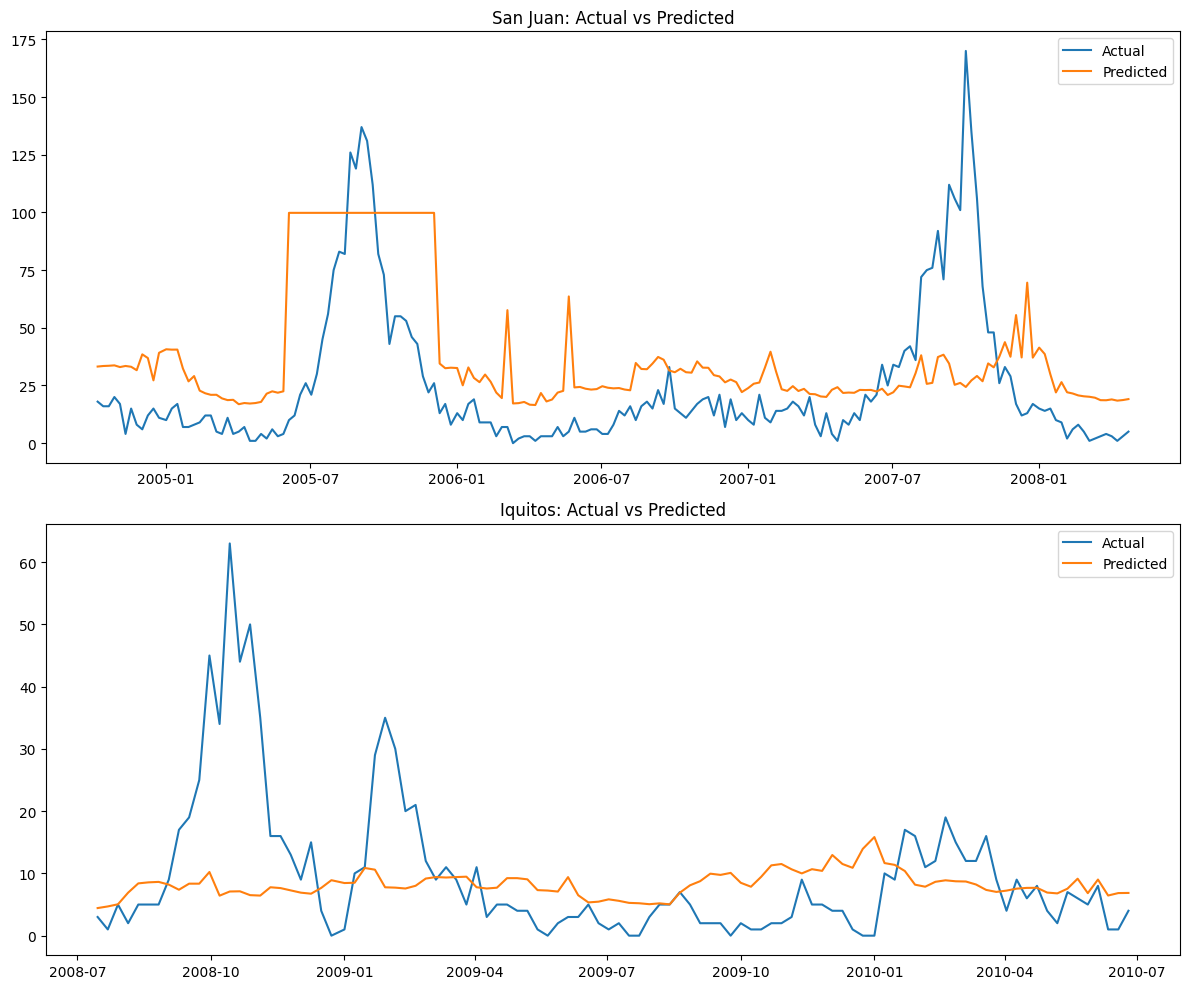

In [10]:
# EVALUATION AND VISUALIZATION

# Evaluate Tuned San Juan
preds_sj_tuned = best_model_sj.predict(X_test_sj)
preds_sj_tuned = np.maximum(preds_sj_tuned, 0)
mae_sj_tuned = mean_absolute_error(y_test_sj, preds_sj_tuned)
print(f"San Juan Tuned MAE: {mae_sj_tuned:.4f}")

# Evaluate Tuned Iquitos
preds_iq_tuned = best_model_iq.predict(X_test_iq)
preds_iq_tuned = np.maximum(preds_iq_tuned, 0)
mae_iq_tuned = mean_absolute_error(y_test_iq, preds_iq_tuned)
print(f"Iquitos Tuned MAE: {mae_iq_tuned:.4f}")

# Plot Results
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# San Juan
ax[0].plot(y_test_sj.index, y_test_sj, label='Actual')
ax[0].plot(y_test_sj.index, preds_sj_tuned, label='Predicted')
ax[0].set_title('San Juan: Actual vs Predicted')
ax[0].legend()

# Iquitos
ax[1].plot(y_test_iq.index, y_test_iq, label='Actual')
ax[1].plot(y_test_iq.index, preds_iq_tuned, label='Predicted')
ax[1].set_title('Iquitos: Actual vs Predicted')
ax[1].legend()

plt.tight_layout()
plt.show()

In [11]:
# FINAL PREDICTIONS ON TEST SET AND SUBMISSION

# 1. Load Test Data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])

sj_test_features = test_features.loc['sj']
iq_test_features = test_features.loc['iq']

# 2. Preprocess Test Data
sj_test = preprocess_city_data(sj_test_features)
iq_test = preprocess_city_data(iq_test_features)

# 3. Feature Engineering for Test Data (handling lags)
def prepare_test_features(train_df, test_df, rolling_weeks=ROLLING_WEEKS):
    """
    Combines train tail with test to generate features without NaNs in test.
    """
    # We need enough history for the largest window
    max_window = max(rolling_weeks) + 10 # buffer
    
    # Get last part of training data (features only)
    # Ensure we only take columns present in test (exclude target if present)
    train_subset = train_df[test_df.columns].tail(max_window)
    
    # Concatenate
    combined = pd.concat([train_subset, test_df])
    
    # Create features
    combined_eng = create_features(combined)
    
    # Slice back the test part
    # We use the index of test_df to slice. 
    # Note: create_features drops rows with NaNs (the beginning of combined).
    # Since we added buffer from train, the test part should be fully preserved.
    test_eng = combined_eng.loc[test_df.index]
    
    return test_eng

print("Generating Test Features...")
sj_test_eng = prepare_test_features(sj_train, sj_test)
iq_test_eng = prepare_test_features(iq_train, iq_test)

# Align test features with training features (select only kept features after pruning)
sj_features_kept = [c for c in sj_train_eng.columns if c != 'total_cases']
iq_features_kept = [c for c in iq_train_eng.columns if c != 'total_cases']

sj_test_eng = sj_test_eng[sj_features_kept]
iq_test_eng = iq_test_eng[iq_features_kept]

print("San Juan Test Shape:", sj_test_eng.shape)
print("Iquitos Test Shape:", iq_test_eng.shape)

# 4. Predict
sj_preds_final = best_model_sj.predict(sj_test_eng)
sj_preds_final = np.maximum(sj_preds_final, 0).astype(int)

iq_preds_final = best_model_iq.predict(iq_test_eng)
iq_preds_final = np.maximum(iq_preds_final, 0).astype(int)

# 5. Create Submission
submission = pd.read_csv(os.path.join(DATA_DIR, "submission_format.csv"), index_col=[0, 1, 2])

# Assign values
submission.loc['sj', 'total_cases'] = sj_preds_final
submission.loc['iq', 'total_cases'] = iq_preds_final

# 6. Save
submission_path = os.path.join(WORKING_DIR, 'results', 'submission_lightgbm.csv')
submission.to_csv(submission_path)
print(f"Submission saved to {submission_path}")
submission.head()

Generating Test Features...
San Juan Test Shape: (260, 281)
Iquitos Test Shape: (156, 323)
Submission saved to C:/Users/malik.kalembasi/OneDrive - Odine Solutions/Desktop/itu/machine_learning/term_project\results\submission_lightgbm.csv


C:\Users\malik.kalembasi\AppData\Local\Temp\ipykernel_16900\1763292133.py:64: PerformanceWarning: indexing past lexsort depth may impact performance.
  submission.loc['sj', 'total_cases'] = sj_preds_final
C:\Users\malik.kalembasi\AppData\Local\Temp\ipykernel_16900\1763292133.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  submission.loc['iq', 'total_cases'] = iq_preds_final


total_cases
city year weekofyear             
sj   2008 18                   19
          19                   18
          20                   62
          21                   58
          22                   22